In [1]:
#!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.0 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [46]:
import warnings
warnings.filterwarnings('ignore')


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from scipy.stats import pointbiserialr
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer
import re
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
import string
import seaborn as sns
import numpy as np
from nltk.tokenize import word_tokenize
import spacy
from transformers import BertTokenizer, BertModel
import torch

[nltk_data] Downloading package stopwords to /home/nina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/nina/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/nina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
fake_news = pd.read_csv('WELFake_Dataset.csv', index_col = 0)

# EDA and Data Cleaning

#### General data exploration

In [4]:
fake_news.columns

Index(['title', 'text', 'label'], dtype='object')

In [5]:
fake_news.shape

(72134, 3)

In [6]:
fake_news.isna().sum()

title    558
text      39
label      0
dtype: int64

In [7]:
# Check for cases when both title and text are nan 
fake_news[fake_news['title'].isna() & fake_news['text'].isna()].shape[0]


0

In [8]:
fake_news['title'].fillna('', inplace=True)
fake_news.dropna(subset=['text'], inplace=True)


In [9]:
# check for class imbalance
fake_news['label'].value_counts()

label
1    37067
0    35028
Name: count, dtype: int64

In [10]:
fake_news.shape

(72095, 3)

In [11]:
# drop duplicated rows
fake_news = fake_news.drop_duplicates()

In [12]:
fake_news.shape

(63639, 3)

In [13]:
# text to lowercase
fake_news['title'] = fake_news['title'].str.lower()
fake_news['text'] = fake_news['text'].str.lower()


#### Text length 

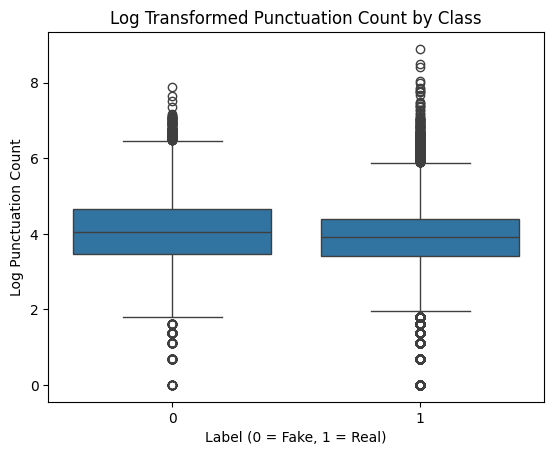

In [14]:
fake_news['punct_count'] = fake_news['text'].str.count(f'[{re.escape(string.punctuation)}]')
fake_news['log_punct_count'] = np.log1p(fake_news['punct_count']) 

sns.boxplot(x='label', y='log_punct_count', data=fake_news)
plt.title('Log Transformed Punctuation Count by Class')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Log Punctuation Count')
plt.show()

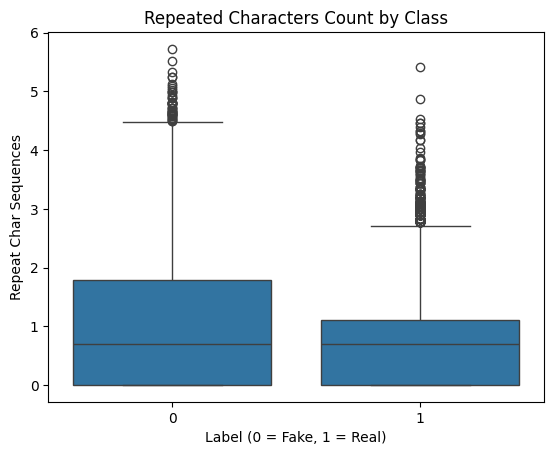

In [15]:
fake_news['repeat_count'] = fake_news['text'].str.count(r'(.)\1{2,}')
fake_news['repeat_count'] = np.log1p(fake_news['repeat_count']) 

sns.boxplot(x='label', y='repeat_count', data=fake_news)
plt.title('Repeated Characters Count by Class')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Repeat Char Sequences')
plt.show()


#### Writing style (punctuation, numbers and long repeated characters)

In [16]:
# removing punctuation, numbers and long repeated characters
fake_news['text'] = fake_news['text'].str.replace(r'[{}]'.format(re.escape(string.punctuation)), '', regex=True)
fake_news['text'] = fake_news['text'].str.replace(r'\d+', '', regex=True)
fake_news['text'] = fake_news['text'].str.replace(r'(.)\1{2,}', r'\1\1', regex=True)

In [17]:
# Remove extra whitespace (multiple spaces, tabs, newlines)
fake_news['text'] = fake_news['text'].str.replace(r'\s+', ' ', regex=True)


#### Text length 



In [18]:
fake_news['text_word_count'] = fake_news['text'].apply(lambda x: len(nltk.word_tokenize(x)))


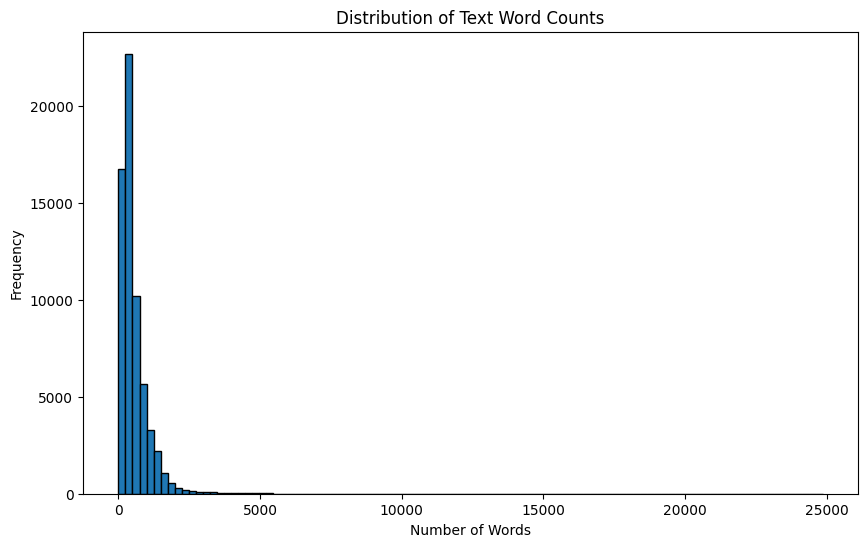

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(fake_news['text_word_count'], bins=100, edgecolor='black')
plt.title('Distribution of Text Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


In [20]:
fake_news['text_word_count'].min()

0

In [21]:
fake_news[fake_news['text_word_count'] != 0]['text_word_count'].min()

1

In [22]:
fake_news[fake_news['text_word_count'] < 20].shape

(1461, 7)

In [23]:
fake_news = fake_news[fake_news['text_word_count'] >20]

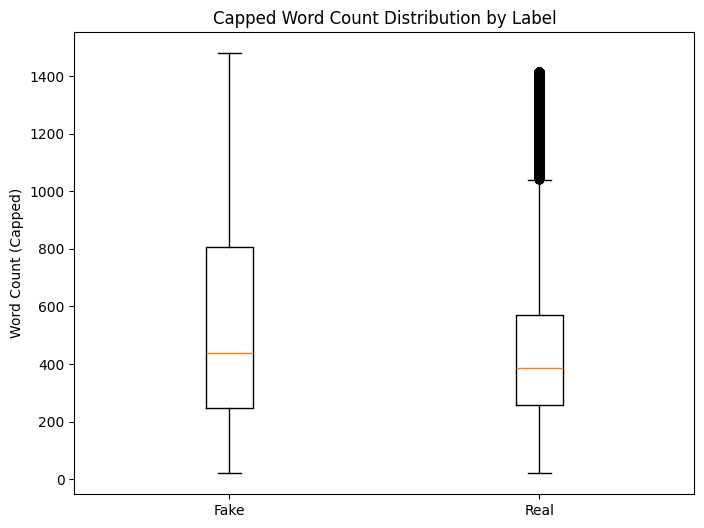

In [24]:
fake_lengths = fake_news[fake_news['label'] == 0]['text_word_count']
real_lengths = fake_news[fake_news['label'] == 1]['text_word_count']

upper_limit_fake = fake_lengths.quantile(0.95)
upper_limit_real = real_lengths.quantile(0.95)

fake_lengths_capped = np.where(fake_lengths > upper_limit_fake, upper_limit_fake, fake_lengths)
real_lengths_capped = np.where(real_lengths > upper_limit_real, upper_limit_real, real_lengths)

plt.figure(figsize=(8,6))
plt.boxplot([fake_lengths_capped, real_lengths_capped], labels=['Fake', 'Real'])
plt.title('Capped Word Count Distribution by Label')
plt.ylabel('Word Count (Capped)')
plt.show()

In [25]:
# correlation between news length and the target
corr_value = fake_news['text_word_count'].corr(fake_news['label'])
print("Pearson correlation between text word count and label:", corr_value)

corr_pb, p_value = pointbiserialr(fake_news['text_word_count'], fake_news['label'])
print("Point-biserial correlation:", corr_pb, "with p-value:", p_value)


Pearson correlation between text word count and label: -0.05574875449939804
Point-biserial correlation: -0.05574875449939824 with p-value: 5.782482915139466e-44


The result is statistically significant but the very weak negative correlation (-0.056) means word count doesn't affect much whether the news is fake or real.

In [26]:
# Tokenizing the text
fake_news["text_tokens"] = fake_news["text"].apply(word_tokenize)
fake_news["title_tokens"] = fake_news["title"].apply(word_tokenize)


In [27]:
fake_news[['text', 'text_tokens']].head()

,text,text_tokens
0,no comment is expected from barack obama membe...,"[no, comment, is, expected, from, barack, obam..."
2,now most of the demonstrators gathered last n...,"[now, most, of, the, demonstrators, gathered, ..."
3,a dozen politically active pastors came here f...,"[a, dozen, politically, active, pastors, came,..."
4,the rs sarmat missile dubbed satan will replac...,"[the, rs, sarmat, missile, dubbed, satan, will..."
5,all we can say on this one is it s about time ...,"[all, we, can, say, on, this, one, is, it, s, ..."


#### word length

In [28]:
# Look if there are too long words
long_words = fake_news['text_tokens'].apply(lambda x: [word for word in x if len(word) > 50])


In [29]:
all_long_words = [word for sublist in long_words for word in sublist]
all_long_words[:2]

['httptheconversationcomancientaboriginalstoriespreservehistoryofariseinsealevel',
 'httpwwnytimescomsciencequantumtheoryexperimentsaidtoprovespookyinteractionshtmlr']

In [30]:
# Since the long words are not actual words and make the data noisy I will delete them
fake_news = fake_news[long_words.apply(len) == 0]

In [31]:
fake_news['avg_word_length'] = fake_news['text_tokens'].apply(lambda x: np.mean([len(word) for word in x]))


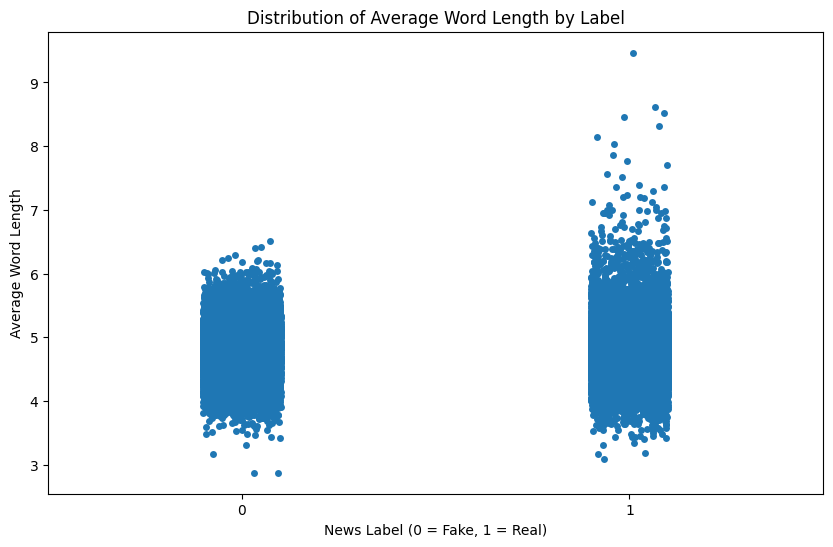

In [32]:
# average word length among classes
plt.figure(figsize=(10, 6))
sns.stripplot(x='label', y='avg_word_length', data=fake_news, jitter=True)
plt.title('Distribution of Average Word Length by Label')
plt.xlabel('News Label (0 = Fake, 1 = Real)')
plt.ylabel('Average Word Length')
plt.show()

#### stopword analysis

In [33]:
stop_words = set(stopwords.words('english'))

In [34]:
fake_news['stop_word_count'] = fake_news['text_tokens'].apply(lambda x: sum([1 for word in x if word in stop_words]))


In [35]:
# average stop word percentage
fake_news['stop_word_percentage'] = fake_news['stop_word_count'] / fake_news['text_word_count'] * 100
np.mean(fake_news['stop_word_percentage'])

41.77793134499296

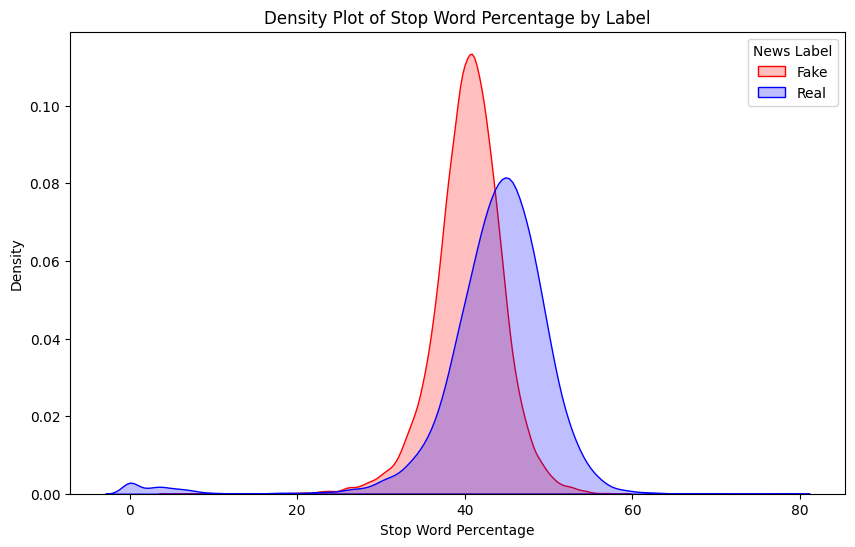

In [36]:
plt.figure(figsize=(10, 6))
sns.kdeplot(fake_news[fake_news['label'] == 0]['stop_word_percentage'], color='red', label='Fake', fill=True)
sns.kdeplot(fake_news[fake_news['label'] == 1]['stop_word_percentage'], color='blue', label='Real', fill=True)

plt.title('Density Plot of Stop Word Percentage by Label')
plt.xlabel('Stop Word Percentage')
plt.ylabel('Density')

plt.legend(title='News Label', labels=['Fake', 'Real'])

plt.show()

#### Language use | Common words

In [37]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=10)
fake_vectorized = vectorizer.fit_transform(fake_news[fake_news['label'] == 0]['text'])
real_vectorized = vectorizer.fit_transform(fake_news[fake_news['label'] == 1]['text'])
fake_grams = vectorizer.get_feature_names_out()
fake_counts = fake_vectorized.sum(axis=0).A1
real_grams = vectorizer.get_feature_names_out()
real_counts = real_vectorized.sum(axis=0).A1

fake_bigram_freq = dict(zip(fake_grams, fake_counts))
real_bigram_freq = dict(zip(real_grams, real_counts))

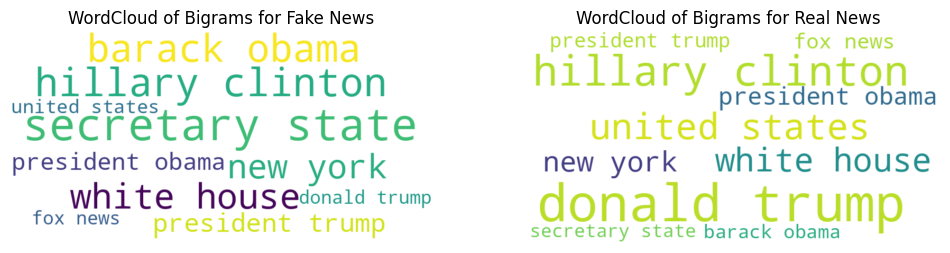

In [38]:
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fake_bigram_freq)

real_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(real_bigram_freq)

plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title('WordCloud of Bigrams for Fake News')
plt.axis('off')

# Real news WordCloud
plt.subplot(1, 2, 2)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.title('WordCloud of Bigrams for Real News')
plt.axis('off')

plt.show()

#### Lemmatization 


In [40]:
fake_news_for_bert = fake_news.copy(deep=True)
fake_news_for_bert = fake_news_for_bert[['title', 'text', 'label']]

In [41]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


In [42]:
title_docs = list(nlp.pipe([" ".join(tokens) for tokens in fake_news['title_tokens']]))
fake_news['title_tokens'] = [
    [token.lemma_ for token in doc if token.is_alpha] for doc in title_docs
]


text_docs = list(nlp.pipe([" ".join(tokens) for tokens in fake_news['text_tokens']]))
fake_news['text_tokens'] = [
    [token.lemma_ for token in doc if token.is_alpha] for doc in text_docs
]


In [43]:
# remove stop words
fake_news['title_tokens'] = fake_news['title_tokens'].apply(
    lambda tokens: [word for word in tokens if word.lower() not in stop_words]
)

fake_news['text_tokens'] = fake_news['text_tokens'].apply(
    lambda tokens: [word for word in tokens if word.lower() not in stop_words])

In [44]:
fake_news = fake_news[['text_tokens','title_tokens','label']]

In [45]:
train_df, test_df = train_test_split(fake_news, test_size=0.2, random_state=4, stratify=fake_news['label'])


In [50]:
train__bert_df, test_bert_df = train_test_split(fake_news_for_bert, test_size=0.2, random_state=4, stratify=fake_news['label'])


In [53]:
train__bert_df.to_csv("data/train_bert_data.csv")
test_bert_df.to_csv("data/test_bert_data.csv")

In [55]:
train_df.shape

(49343, 3)

In [56]:
test_df.shape

(12336, 3)

In [57]:
train_df.to_csv("data/train_data.csv")
test_df.to_csv("data/test_data.csv")